1\. Fodrászonként mekkora Bevételt produkált a szalon, illetve mennyi az össz bevétel

2.Picit bonyolultabban --\> Fodrászonként és szolgáltatásonként a bevétel összege

In [ ]:
select IIF(GROUPING(fodraszok.nev) = 1, 'Összesen', fodraszok.nev) AS 'Fodrász neve',
       SUM(szolgaltatasok.ar*kedvezmeny.szazalek) AS 'Bevétel'
FROM foglalasok join fodraszok on foglalasok.fodrasz_fk = fodraszok.fodrasz_id
				join foglalas_szolgaltatas on foglalasok.foglalas_id = foglalas_szolgaltatas.foglalas_fk
                join szolgaltatasok on foglalas_szolgaltatas.szolgaltatas_fk = szolgaltatasok.szolgaltatas_id
                join kedvezmeny on kedvezmeny.kedvezmeny_id = szolgaltatasok.kedvezmeny_fk
group by rollup(fodraszok.nev)


In [ ]:
SELECT IIF(GROUPING_ID(fodraszok.nev) = 1, 'Végösszeg',fodraszok.nev) as 'Fodrász neve',
        CASE 
        when grouping_id(fodraszok.nev, szolgaltatasok.megnevezes) = 1 THEN 'Részösszeg'
        when grouping_id(fodraszok.nev, szolgaltatasok.megnevezes) = 3 THEN 'Végösszeg'
        else szolgaltatasok.megnevezes
        end as 'Szolgáltatás neve',
        SUM(szolgaltatasok.ar*kedvezmeny.szazalek) AS 'Bevétel'
FROM foglalasok join fodraszok on foglalasok.fodrasz_fk = fodraszok.fodrasz_id
				join foglalas_szolgaltatas on foglalasok.foglalas_id = foglalas_szolgaltatas.foglalas_fk
                join szolgaltatasok on foglalas_szolgaltatas.szolgaltatas_fk = szolgaltatasok.szolgaltatas_id
                join kedvezmeny on kedvezmeny.kedvezmeny_id = szolgaltatasok.kedvezmeny_fk
group by rollup(fodraszok.nev,szolgaltatasok.megnevezes)

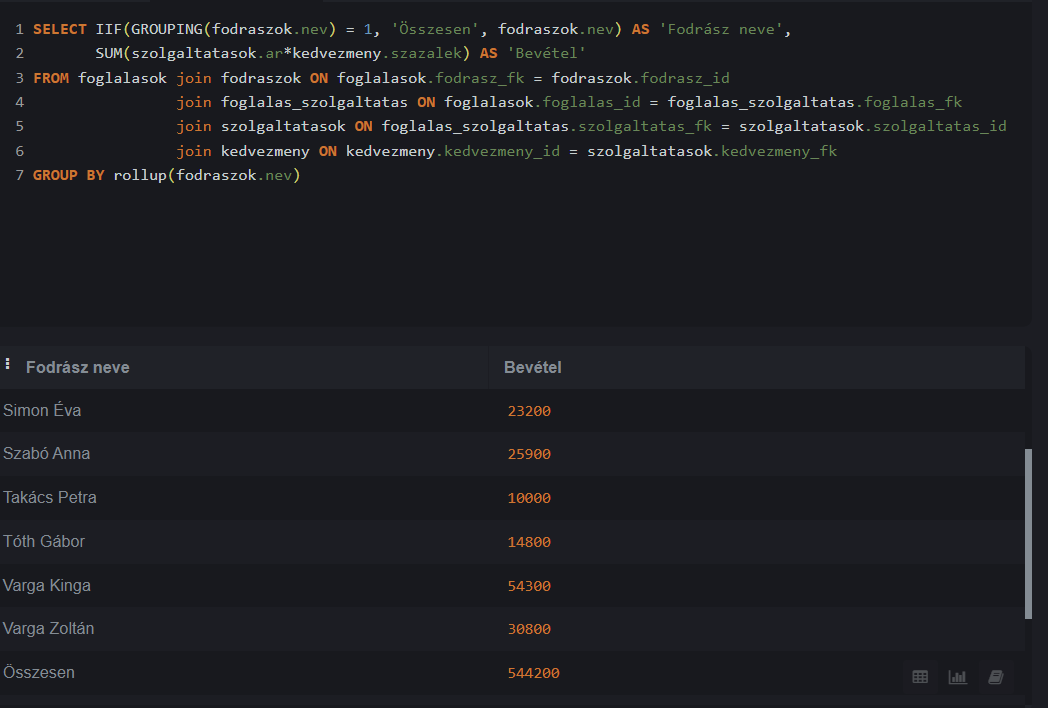

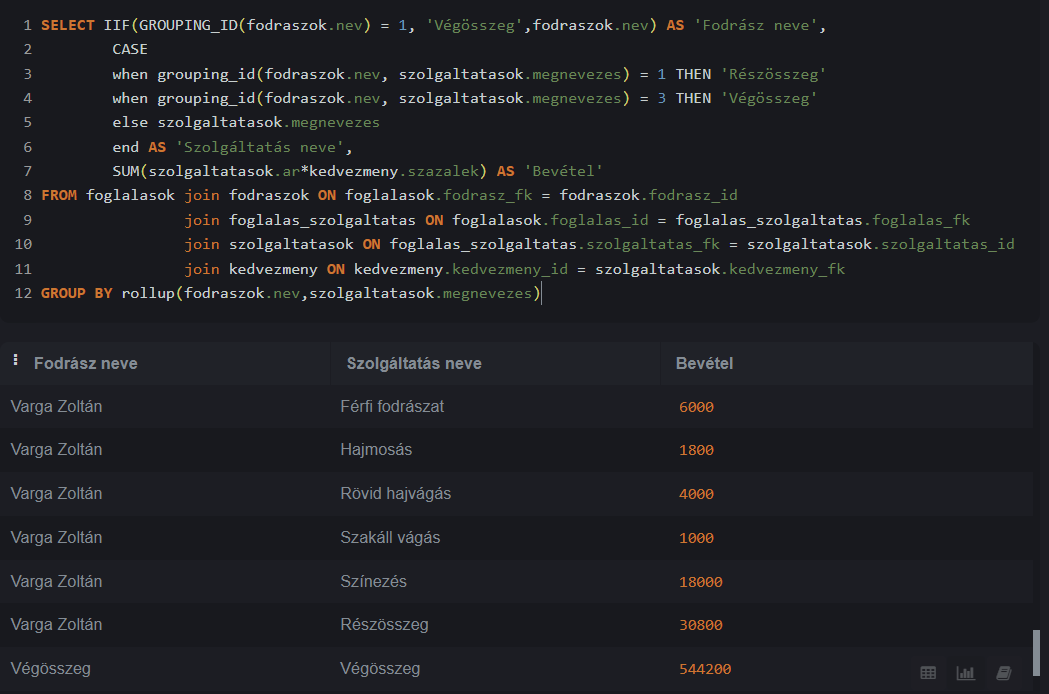

3\. Foglalások szerint az ügyfél neve jelenik meg és az előtte foglaló ügyfél neve. Plusz kikötés, hogy csak azok a foglalások jelennek meg ahol a fodrász hétvégén is dolgozik.

In [ ]:
SELECT ugyfelek.nev AS 'Ügyfél neve',lag(ugyfelek.nev,1,'Nincs') over(order by foglalasok.idopont) as 'Előtte lévő ügyfél neve'
FROM ugyfelek join foglalasok on ugyfelek.ugyfel_id = foglalasok.ugyfel_fk
WHERE foglalasok.fodrasz_fk in (
  Select fodraszok.fodrasz_id
  from fodraszok join fodraszok_munkanapok on fodraszok.fodrasz_id = fodraszok_munkanapok.fodrasz_fk
  				 join munkanapok on munkanapok.munkanap_id = fodraszok_munkanapok.munkanap_fk
  WHERE munkanapok.nap in ('Szombat','Vasárnap'))

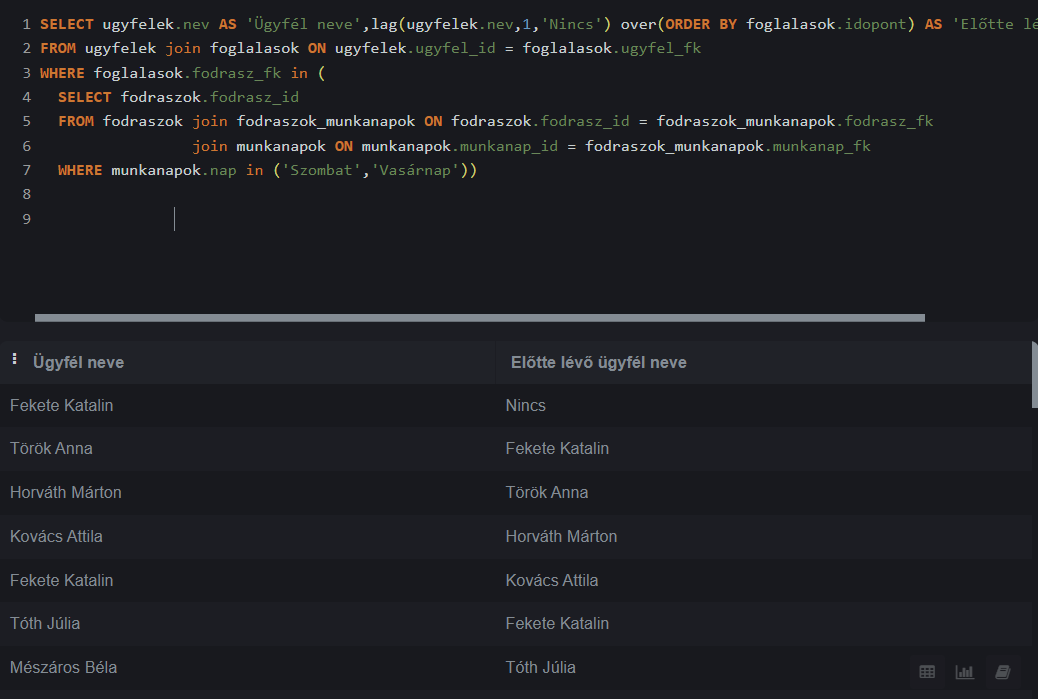

4\. Szolgáltatások árkategóriába sorolása

In [ ]:
SELECT megnevezes AS 'Megnevezés', ar AS 'Ár',
    CASE 
        WHEN ar < 5000 THEN 'Olcsó árkategória'
        WHEN ar >= 5000 AND ar < 10000 THEN 'Közepes árkategória'
        WHEN ar >= 10000 THEN 'Drága árkategória'
    END AS 'Árkategória',
    AVG(ar) OVER (PARTITION BY
        CASE 
            WHEN ar < 5000 THEN 'Olcsó árkategória'
            WHEN ar >= 5000 AND ar < 10000 THEN 'Közepes árkategória'
            WHEN ar >= 10000 THEN 'Drága árkategória'
        END
    ) AS 'Árkategória átlagár'
FROM szolgaltatasok

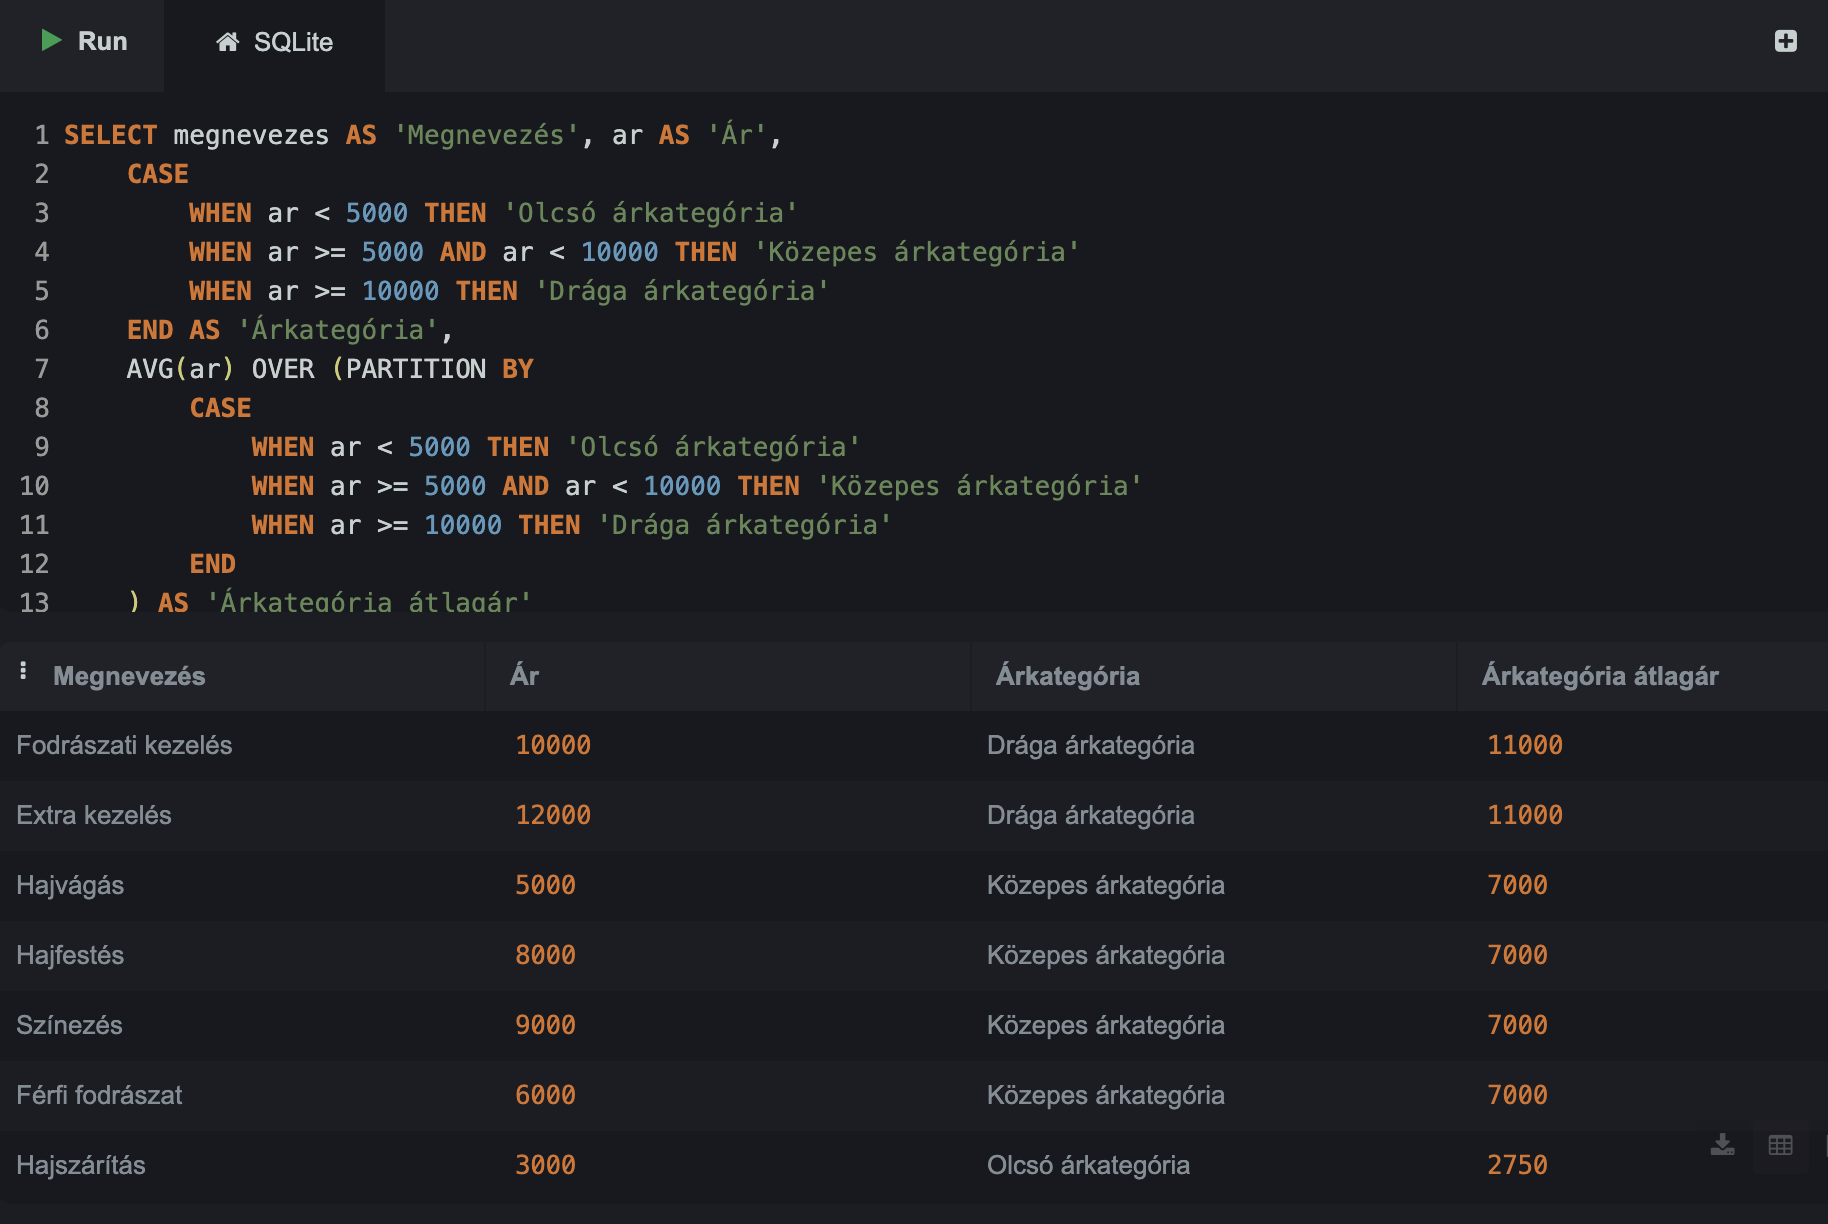

5\. Fodrászok és az eddigi foglalásainak darabszáma

In [ ]:
SELECT  fodraszok.nev  as 'Fodrász neve',
		foglalasok.foglalas_id as 'Foglalás azonosítója', 
		count(foglalasok.foglalas_id) 
        over(partition by fodraszok.fodrasz_id 
             order by foglalasok.idopont 
             range between unbounded preceding and current row) as 'Foglalások darabszáma'
FROM foglalasok join fodraszok on foglalasok.fodrasz_fk = fodraszok.fodrasz_id
order by foglalasok.idopont

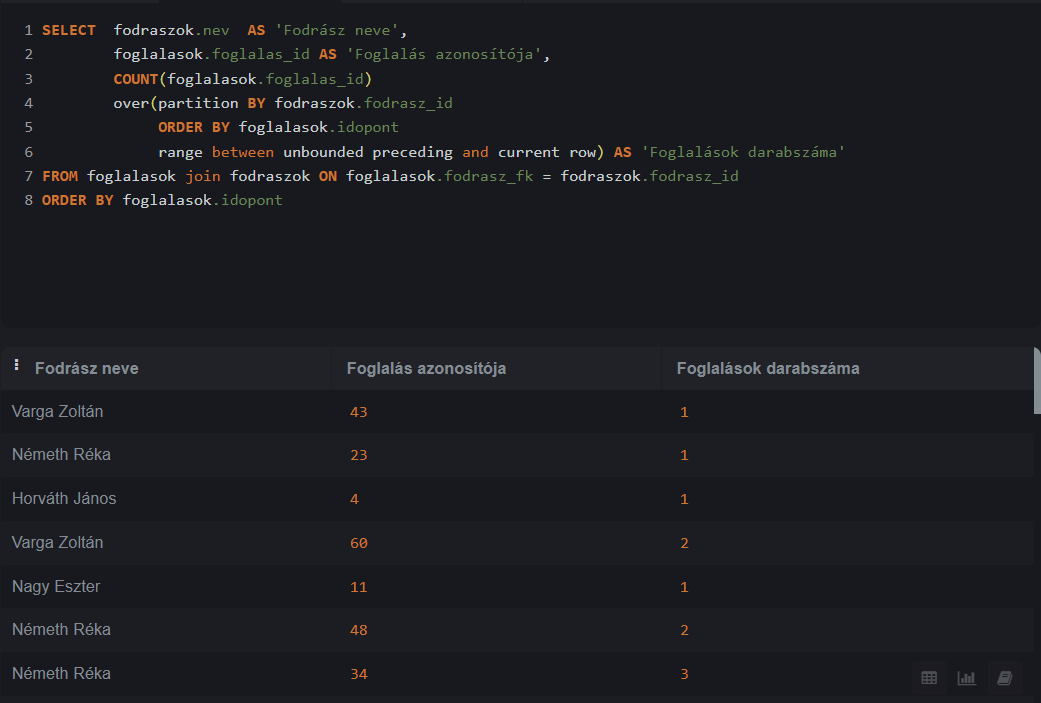

6. Hány olyan rendelés van ahol a foglalás kezdete eltér a tényleges kezdétől

In [ ]:
SELECT COUNT(*) AS "Eltérések száma"
FROM foglalasok
WHERE idopont != kezdes;

--33

7. A mai napon melyik fodrászoknak milyen időpontja lesz

In [ ]:
SELECT fd.nev AS 'Fodrász',
		f.idopont AS 'Időpont',
        u.nev AS 'Ügyfél',
        sz.megnevezes AS 'Szolgáltatás'
FROM foglalasok f JOIN fodraszok fd ON f.fodrasz_fk = fd.fodrasz_id
					JOIN ugyfelek u ON f.ugyfel_fk = u.ugyfel_id
                    JOIN  foglalas_szolgaltatas fsz ON f.foglalas_id = fsz.foglalas_fk
                    JOIN szolgaltatasok sz ON fsz.szolgaltatas_fk = sz.szolgaltatas_id
WHERE CONVERT(DATE, f.idopont) = CONVERT(DATE, GETDATE());

![Nincs elérhető leírás.](https://scontent-vie1-1.xx.fbcdn.net/v/t1.15752-9/436616824_2085847431801322_8450018736212734062_n.png?_nc_cat=100&ccb=1-7&_nc_sid=5f2048&_nc_ohc=WAxdN_hJEvkQ7kNvgEFfy-P&_nc_ht=scontent-vie1-1.xx&oh=03_Q7cD1QEHiWnSg6WXn-Wnp-ngC9GkId9jk7ZI0CNTfXUg-8nUDg&oe=6669749D)

8\. Azon ügyfelek neve és foglalása, akik az átlagnál régebben voltak utoljára a szalonba. Májusi foglalások vannak az adatbázisban, így áprilissal bezárólag nézzük az utolsó látogatást

In [ ]:
select ugyfelek.nev as 'Név',foglalasok.foglalas_id as 'Foglalás'
FROM ugyfelek join foglalasok on ugyfelek.ugyfel_id = foglalasok.ugyfel_fk
where datediff(day,ugyfelek.legutobbi_latogatas,'2024.05.01') > 
	 (SELECt avg(datediff(day,ugyfelek.legutobbi_latogatas,'2024.05.01'))
	  FROM ugyfelek)

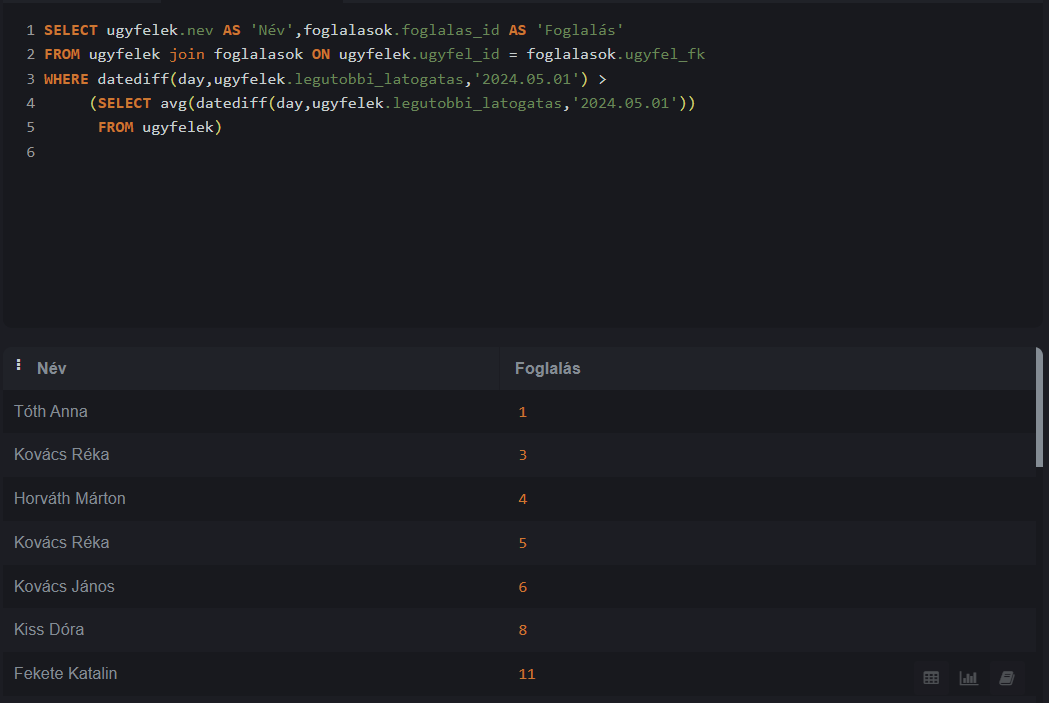